In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#pd.set_option('display.max_rows', None)  # or 1000

In [3]:
#Import Packages
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
#import networkx as nx
#from urllib import parse
#from scipy import stats
#from functools import reduce
#from pandas_profiling import ProfileReport
import numpy as np
#import scipy.sparse
#import scipy.sparse.csgraph

# 0 Load the necessary data

In [4]:
df_links_tdc_comb = pd.read_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/df_links_tdc_comb.csv', low_memory=False)
#read in the df_links_tdc_comb dataframe

In [5]:
innovateUK = pd.read_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/innovateUK.csv', low_memory=False)
#read in the innovateUK data

# 8 Training Set Generation

The training set will be generated in two stages. First, we will use the linking data. Second we will use the InnovateUK data.

We will have four different variations of training sets: 
  - First Approach of 1.25% from top & bottom and innovateUK
      - TrainingSet 1
  - 0.5% and innovateUK
      - Trainingset 2
  - only innovateUK + negatives from Link Building
      - Trainingset 3
  - only first Approach
      - Trainingset 4
      
      
It is important to mention here that the model results of the respective training sets are NOT comparable. It will be comparable if we take a look on actual probabilities later on.

## 8.1 Linking Data

#### Initial Steps - Analysis

In [6]:
percentages=df_links_tdc_comb['SICHLU'].value_counts().reset_index()#calculate the relative importance of each
#SICHLU code to know how to set up the training set. Reason: To not over or underrepresent a category

In [7]:
percentages['perc_total'] = percentages['SICHLU'] / percentages['SICHLU'].sum()
percentages#show percentages per SICHLU category

,index,SICHLU,perc_total
0,M,92908,0.152794
1,G,86954,0.143002
2,N,65396,0.107548
3,J,65081,0.107030
4,F,60774,0.099947
5,C,59370,0.097638
6,S,28002,0.046051
7,R,20568,0.033825
8,L,20170,0.033171
9,Q,19477,0.032031


#### Links_TS 1

In [8]:
def SICHLU_TS_GENERATOR(SICHLU: str):
    ''' This function takes the combined df and returns
    the top 1.25% and bottom 1.25% of each SICHLU category.
    '''
    df = df_links_tdc_comb[df_links_tdc_comb['SICHLU']==SICHLU].sort_values(by='pagerank', ascending=False)
    number = int(round(len(df)*0.0125,0))
    df1 = df.nlargest(number, columns='pagerank')
    df2 = df.nsmallest(number, columns='pagerank')
    df1['isInnovative'] = 1
    df2['isInnovative'] = 0
    df = pd.concat([df1, df2])
    return df

In [9]:
sichlus_list = ['M', 'G', 'N', 'F', 'C', 'J', 'S', 'L', 'K', 'Q', 'U', 'R', 'I', 'H', 'P', 'A', 'E', 'T', 'D', 'B', 'O']
sichlus_dfs = []

for letter in sichlus_list:#a foor loop applying the function to each SICHLU group and giving final df
    df = SICHLU_TS_GENERATOR(letter)
    sichlus_dfs.append(df)
    
Links_TS1 = pd.concat(sichlus_dfs)
Links_TS1['Origin'] = 'Links'#add from where the training set instance comes

(array([1.516e+04, 2.100e+01, 7.000e+00, 8.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.96017872e-07, 3.40337389e-05, 6.77714599e-05, 1.01509181e-04,
        1.35246902e-04, 1.68984623e-04, 2.02722344e-04, 2.36460065e-04,
        2.70197786e-04, 3.03935507e-04, 3.37673228e-04]),
 <a list of 10 Patch objects>)

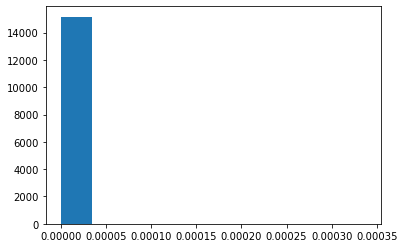

In [10]:
plt.hist(Links_TS1['pagerank'])#visualize indegree distribution

(array([1.5139e+04, 3.4000e+01, 1.3000e+01, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.83402653e-07, 3.14006772e-04, 6.27630142e-04, 9.41253512e-04,
        1.25487688e-03, 1.56850025e-03, 1.88212362e-03, 2.19574699e-03,
        2.50937036e-03, 2.82299373e-03, 3.13661710e-03]),
 <a list of 10 Patch objects>)

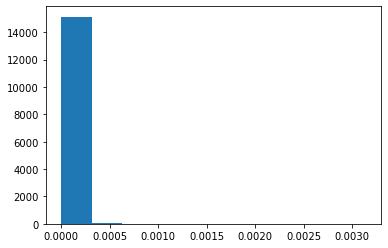

In [11]:
plt.hist(Links_TS1['indegree_centrality'])#visualize indegree distribution

In [12]:
len(Links_TS1)

15202

#### Links_TS 2

In [13]:
def SICHLU_TS_GENERATOR(SICHLU: str):
    ''' This function takes the combined df and returns
    the top 0.25% and bottom 0.25% of each SICHLU category.
    '''
    df = df_links_tdc_comb[df_links_tdc_comb['SICHLU']==SICHLU].sort_values(by='pagerank', ascending=False)
    number = int(round(len(df)*0.0025,0))
    df1 = df.nlargest(number, columns='pagerank')
    df2 = df.nsmallest(number, columns='pagerank')
    df1['isInnovative'] = 1
    df2['isInnovative'] = 0
    df = pd.concat([df1, df2])
    return df

In [14]:
sichlus_list = ['M', 'G', 'N', 'F', 'C', 'J', 'S', 'L', 'K', 'Q', 'U', 'R', 'I', 'H', 'P', 'A', 'E', 'T', 'D', 'B', 'O']
sichlus_dfs = []

for letter in sichlus_list:#a foor loop applying the function to each SICHLU group and giving final df
    df = SICHLU_TS_GENERATOR(letter)
    sichlus_dfs.append(df)
    
Links_TS2 = pd.concat(sichlus_dfs)
Links_TS2['Origin'] = 'Links'#add from where the training set instance comes

(array([2.994e+03, 2.100e+01, 7.000e+00, 8.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.96017872e-07, 3.40337389e-05, 6.77714599e-05, 1.01509181e-04,
        1.35246902e-04, 1.68984623e-04, 2.02722344e-04, 2.36460065e-04,
        2.70197786e-04, 3.03935507e-04, 3.37673228e-04]),
 <a list of 10 Patch objects>)

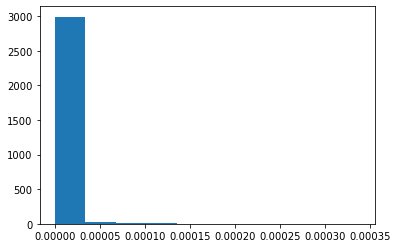

In [15]:
plt.hist(Links_TS2['pagerank'])#visualize indegree distribution

(array([2.973e+03, 3.400e+01, 1.300e+01, 8.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([3.83402653e-07, 3.14006772e-04, 6.27630142e-04, 9.41253512e-04,
        1.25487688e-03, 1.56850025e-03, 1.88212362e-03, 2.19574699e-03,
        2.50937036e-03, 2.82299373e-03, 3.13661710e-03]),
 <a list of 10 Patch objects>)

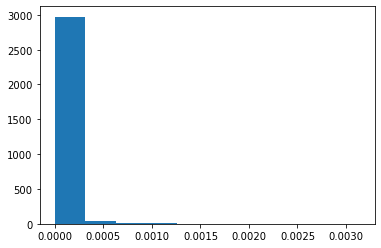

In [16]:
plt.hist(Links_TS2['indegree_centrality'])#visualize indegree distribution

In [17]:
len(Links_TS2)

3036

#### Links_TS 3

In [18]:
def SICHLU_TS_GENERATOR(SICHLU: str):
    ''' This function takes the combined df and returns
    the bottom 2.5% of each SICHLU category.
    '''
    df = df_links_tdc_comb[df_links_tdc_comb['SICHLU']==SICHLU].sort_values(by='pagerank', ascending=False)
    number = int(round(len(df)*0.025,0))
    number2 = int(round(len(df)*0.0,0))
    df1 = df.nlargest(number2, columns='pagerank')
    df2 = df.nsmallest(number, columns='pagerank')
    df1['isInnovative'] = 1
    df2['isInnovative'] = 0
    df = pd.concat([df1, df2])
    return df

In [19]:
sichlus_list = ['M', 'G', 'N', 'F', 'C', 'J', 'S', 'L', 'K', 'Q', 'U', 'R', 'I', 'H', 'P', 'A', 'E', 'T', 'D', 'B', 'O']
sichlus_dfs = []

for letter in sichlus_list:#a foor loop applying the function to each SICHLU group and giving final df
    df = SICHLU_TS_GENERATOR(letter)
    sichlus_dfs.append(df)
    
Links_TS3 = pd.concat(sichlus_dfs)
Links_TS3['Origin'] = 'Links'#add from where the training set instance comes

(array([ 875., 1552., 1824., 2445., 2738., 2629., 1896.,  822.,  247.,
         173.]),
 array([2.96017872e-07, 2.97645031e-07, 2.99272190e-07, 3.00899349e-07,
        3.02526508e-07, 3.04153667e-07, 3.05780826e-07, 3.07407985e-07,
        3.09035144e-07, 3.10662303e-07, 3.12289462e-07]),
 <a list of 10 Patch objects>)

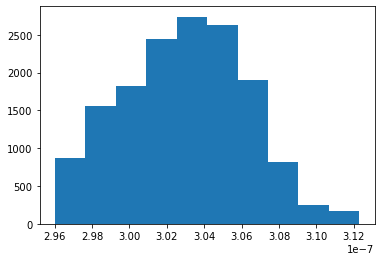

In [20]:
plt.hist(Links_TS3['pagerank'])#visualize indegree distribution

(array([1.3535e+04, 0.0000e+00, 1.4720e+03, 0.0000e+00, 1.6700e+02,
        0.0000e+00, 2.1000e+01, 5.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.83402653e-07, 5.75103979e-07, 7.66805305e-07, 9.58506631e-07,
        1.15020796e-06, 1.34190928e-06, 1.53361061e-06, 1.72531194e-06,
        1.91701326e-06, 2.10871459e-06, 2.30041592e-06]),
 <a list of 10 Patch objects>)

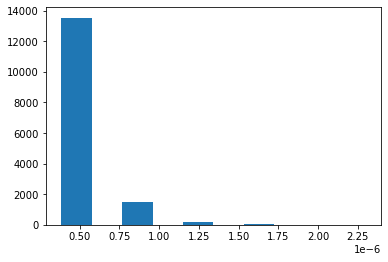

In [21]:
plt.hist(Links_TS3['indegree_centrality'])#visualize indegree distribution

In [22]:
len(Links_TS3)

15201

#### Links_TS 4

In [23]:
def SICHLU_TS_GENERATOR(SICHLU: str):
    ''' This function takes the combined df and returns
    the top 2.5% and bottom 2.5% of each SICHLU category.
    '''
    df = df_links_tdc_comb[df_links_tdc_comb['SICHLU']==SICHLU].sort_values(by='pagerank', ascending=False)
    number = int(round(len(df)*0.025,0))
    df1 = df.nlargest(number, columns='pagerank')
    df2 = df.nsmallest(number, columns='pagerank')
    df1['isInnovative'] = 1
    df2['isInnovative'] = 0
    df = pd.concat([df1, df2])
    return df

In [24]:
sichlus_list = ['M', 'G', 'N', 'F', 'C', 'J', 'S', 'L', 'K', 'Q', 'U', 'R', 'I', 'H', 'P', 'A', 'E', 'T', 'D', 'B', 'O']
sichlus_dfs = []

for letter in sichlus_list:#a foor loop applying the function to each SICHLU group and giving final df
    df = SICHLU_TS_GENERATOR(letter)
    sichlus_dfs.append(df)
    
Links_TS4 = pd.concat(sichlus_dfs)
Links_TS4['Origin'] = 'Links'#add from where the training set instance comes

(array([3.036e+04, 2.100e+01, 7.000e+00, 8.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.96017872e-07, 3.40337389e-05, 6.77714599e-05, 1.01509181e-04,
        1.35246902e-04, 1.68984623e-04, 2.02722344e-04, 2.36460065e-04,
        2.70197786e-04, 3.03935507e-04, 3.37673228e-04]),
 <a list of 10 Patch objects>)

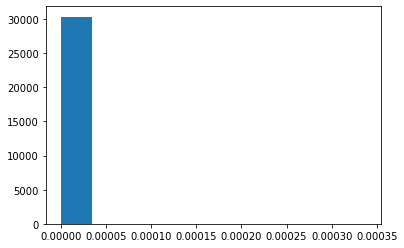

In [25]:
plt.hist(Links_TS4['pagerank'])#visualize indegree distribution

(array([3.0339e+04, 3.4000e+01, 1.3000e+01, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.83402653e-07, 3.14006772e-04, 6.27630142e-04, 9.41253512e-04,
        1.25487688e-03, 1.56850025e-03, 1.88212362e-03, 2.19574699e-03,
        2.50937036e-03, 2.82299373e-03, 3.13661710e-03]),
 <a list of 10 Patch objects>)

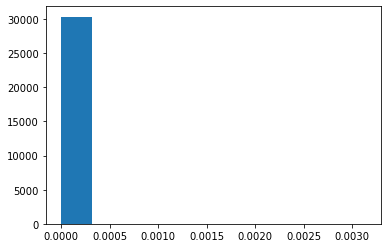

In [26]:
plt.hist(Links_TS4['indegree_centrality'])#visualize indegree distribution

In [27]:
len(Links_TS4)

30402

In [28]:
df_links_tdc_comb.dtypes

CompanyNumber              object
Homepage_domain            object
RegisteredPostcode         object
SIC                       float64
SICHLU                     object
Source                     object
Target                     object
pagerank                  float64
indegree_centrality       float64
outdegree_centrality      float64
eigenvector_centrality    float64
dtype: object

In [29]:
df_links_tdc_comb['CompanyNumber'] = df_links_tdc_comb['CompanyNumber'].astype(str)
df_links_tdc_comb['CompanyNumber'] = df_links_tdc_comb['CompanyNumber'].astype("string")
innovateUK['CRN'] = innovateUK['CRN'].astype(str)
innovateUK['CRN'] = innovateUK['CRN'].astype("string")

In [30]:
df_links_tdc_comb.dtypes

CompanyNumber              string
Homepage_domain            object
RegisteredPostcode         object
SIC                       float64
SICHLU                     object
Source                     object
Target                     object
pagerank                  float64
indegree_centrality       float64
outdegree_centrality      float64
eigenvector_centrality    float64
dtype: object

## 8.2 InnovateUK Training Set

In [31]:
innovateUK.head(30)#we have CRN - Company Registry Number

,Competition Reference,Competition Title,Programme Title,Sector,Application Number,Project Number,Project Title,Public Description,Competition Year,Innovate UK \nProduct Type,...,Actual Spend to Date (£),Participant Withdrawn From Project,Project Status,Enterprise Size,Postcode,Address Region,Address LEP,Address Local Authority,In Multiple LEPs,Industrial Strategy Challenge Fund (ISCF)
0,CATAPULTS,Catapult Activity,Smart Factory Test Bed Pilot Sprints,Manufacturing & Materials,NaN,900185,Fast Start Pilot Sprints,NaN,2021/22,Collaborative R&D,...,-,Active,Live,Catapult,B90 8AD,West Midlands,Greater Birmingham and Solihull,Solihull,No,Yes
1,2010_ISCF_SSPP_FUTURE_PLASTIC,ISCF Future Plastic Packaging Solutions,SSPP Feasibility Studies & Industrial Research...,"Manufacturing, Materials & Mobility",10000497,10000497,Developing a solution to eliminate dish soap p...,Homethings is a producer of household cleaning...,2021/22,Feasibility Studies,...,-,Active,Live,Micro/Small,WC2H 9JQ,London,London,Camden,No,Yes
2,2010_ISCF_SSPP_FUTURE_PLASTIC,ISCF Future Plastic Packaging Solutions,SSPP Feasibility Studies & Industrial Research...,"Manufacturing, Materials & Mobility",10000638,10000638,Notpla Pearls: A seaweed based alternative to ...,The world's annual consumption of plastics has...,2021/22,Feasibility Studies,...,-,Active,Live,Micro/Small,E9 5EN,London,London,Tower Hamlets,No,Yes
3,2008_ISCF_DER_BLUE,Driving the Electric Revolution Blue Zone,Driving the Electric Revolution Blue Zone 2020,Clean Growth & Infrastructure,00043784,43784,MABEL – Optimising through Life Cost of Indust...,MABEL comprises seven work packages aimed at i...,2020/21,Collaborative R&D,...,19'537,Active,Live,Medium,NE11 0QD,North East,North Eastern,Gateshead,No,Yes
4,2008_ISCF_DER_BLUE,Driving the Electric Revolution Blue Zone,Driving the Electric Revolution Blue Zone 2020,Clean Growth & Infrastructure,00043784,43784,MABEL – Optimising through Life Cost of Indust...,MABEL comprises seven work packages aimed at i...,2020/21,Collaborative R&D,...,-,Active,Live,Academic,NE1 7RU,North East,North Eastern,Newcastle upon Tyne,No,Yes
5,1910_CRD_DFID_AGRITECH_R9_MS,448 - Agri-Tech Catalyst Round 9: Agriculture ...,Agri-Tech Catalyst Round 9: Agriculture and Fo...,"Ageing Society, Health & Nutrition",00045568,45568,Bee Smart: Improving yields for cashew growers...,"Honeybees are vital pollinators, both to the a...",2020/21,Feasibility Studies,...,26'118,Active,Live,Micro/Small,KT2 6DZ,London,London,Kingston upon Thames,No,No
6,1910_CRD_DFID_AGRITECH_R9_MS,448 - Agri-Tech Catalyst Round 9: Agriculture ...,Agri-Tech Catalyst Round 9: Agriculture and Fo...,"Ageing Society, Health & Nutrition",00045568,45568,Bee Smart: Improving yields for cashew growers...,"Honeybees are vital pollinators, both to the a...",2020/21,Feasibility Studies,...,7'277,Active,Live,Academic,KT1 2EE,London,London,Kingston upon Thames,No,No
7,1910_CRD_DFID_AGRITECH_R9_MS,448 - Agri-Tech Catalyst Round 9: Agriculture ...,Agri-Tech Catalyst Round 9: Agriculture and Fo...,"Ageing Society, Health & Nutrition",00045568,45568,Bee Smart: Improving yields for cashew growers...,"Honeybees are vital pollinators, both to the a...",2020/21,Feasibility Studies,...,27'153,Active,Live,PSO,NaN,Outside UK,NaN,NaN,No,No
8,1910_CRD_DFID_AGRITECH_R9_MS,448 - Agri-Tech Catalyst Round 9: Agriculture ...,Agri-Tech Catalyst Round 9: Agriculture and Fo...,"Ageing Society, Health & Nutrition",00045568,45568,Bee Smart: Improving yields for cashew growers...,"Honeybees are vital pollinators, both to the a...",2020/21,Feasibility Studies,...,3'012,Active,Live,RTO,NaN,Outside UK,NaN,NaN,No,No
9,1910_CRD_DFID_AGRITECH_R9_ES,447 - Agri-Tech Catalyst Round 9: Agriculture ...,Agri-Tech Catalyst Round 9: Agriculture and Fo...,"Ageing Society, Health & Nutrition",00047259,47259,Innovations in soil and irrigation technologie...,Cultivating high-value vegetables for both nat...,2020/21,Feasibility Studies,...,14'481,Active,Live,Academic,MK43

In [32]:
CRN = innovateUK['CRN'] #create a series with all company numbers which were supported by innovateUK since 2014
CRN.dropna(inplace=True)

In [33]:
#keep the companies which are in CRN only
innovateUK_TS = df_links_tdc_comb[df_links_tdc_comb['CompanyNumber'].isin(CRN)].copy()

In [34]:
innovateUK_TS['isInnovative'] = 1 #all companies in this df are "innovative"
innovateUK_TS['Origin'] = 'innovateUK' #add the origine for later to know
len(innovateUK_TS)

6570

As there are many companies, we will take a random 1500 companies from the dataset.

In [35]:
InnovateUK_TS_Final = innovateUK_TS.sample(1500)#pick randomly 1500 rows

In [36]:
len(InnovateUK_TS_Final)#was successful

1500

## 8.3 Training Set prior Website Text

In [37]:
TrainingSet1 = pd.concat([Links_TS1, InnovateUK_TS_Final])#concat the two training sets

In [38]:
len(TrainingSet1)

16702

In [39]:
TrainingSet2 = pd.concat([Links_TS2, InnovateUK_TS_Final])#concat the two training sets

In [40]:
len(TrainingSet2)

4536

In [41]:
TrainingSet3 = pd.concat([Links_TS3, InnovateUK_TS_Final])#concat the two training sets

In [42]:
len(TrainingSet3)

16701

In [59]:
TrainingSet4 = Links_TS4.copy()#concat the two training sets

In [60]:
len(TrainingSet4)

30402

# 9 Final Trainingset incl. WebText

Now we will read in the website text of all companies and clean the website text. As the text is received relatively clean already and an initial lit review showed there is no absolute advantage of extensive cleaning such as stemming, the author will avoid such methods.

All steps will be carried out four times to prepare the four distinct training sets.

#### TrainingSet 1

In [45]:
#create a list with all company numbers
company_nums = TrainingSet1['CompanyNumber']

#create an empty list for the dtaframes
dataframes = []

#open the connection to the database
con = sqlite3.connect("/Users/Michael/Desktop/OrganisationMLLite_Mar2021.db")

#loop over each row in the database to avoid loading everything into memory and the kernel from dying
for company_num in company_nums:
    webtext = pd.read_sql_query(f'SELECT CompanyNumber, CompanyWebText FROM OrganisationML WHERE CompanyNumber == "{company_num}"', con)
    dataframes.append(webtext)#add the row to the list of dataframes
    
all_data1 = pd.concat(dataframes)#concat all dataframes together

#close the database connection
con.close()

In [46]:
#check, did we get the entire text?
#all_data["CompanyWebText"].iloc[1] #the db only holds the first 50K characters and not entire text

In [47]:
final1 = all_data1.merge(TrainingSet1, on="CompanyNumber", how='inner')#add all_data and website text

In [48]:
final1.to_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/final1.csv', index=False)


#### Trainingset 2

In [49]:
#create a list with all company numbers
company_nums = TrainingSet2['CompanyNumber']

#create an empty list for the dtaframes
dataframes = []

#open the connection to the database
con = sqlite3.connect("/Users/Michael/Desktop/OrganisationMLLite_Mar2021.db")

#loop over each row in the database to avoid loading everything into memory and the kernel from dying
for company_num in company_nums:
    webtext = pd.read_sql_query(f'SELECT CompanyNumber, CompanyWebText FROM OrganisationML WHERE CompanyNumber == "{company_num}"', con)
    dataframes.append(webtext)#add the row to the list of dataframes
    
all_data2 = pd.concat(dataframes)#concat all dataframes together

#close the database connection
con.close()

In [50]:
final2 = all_data2.merge(TrainingSet2, on="CompanyNumber", how='inner')#add all_data and website text

In [51]:
final2.to_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/final2.csv', index=False)


#### Trainingset 3

In [52]:
#create a list with all company numbers
company_nums = TrainingSet3['CompanyNumber']

#create an empty list for the dtaframes
dataframes = []

#open the connection to the database
con = sqlite3.connect("/Users/Michael/Desktop/OrganisationMLLite_Mar2021.db")

#loop over each row in the database to avoid loading everything into memory and the kernel from dying
for company_num in company_nums:
    webtext = pd.read_sql_query(f'SELECT CompanyNumber, CompanyWebText FROM OrganisationML WHERE CompanyNumber == "{company_num}"', con)
    dataframes.append(webtext)#add the row to the list of dataframes
    
all_data3 = pd.concat(dataframes)#concat all dataframes together

#close the database connection
con.close()

In [53]:
final3 = all_data3.merge(TrainingSet3, on="CompanyNumber", how='inner')#add all_data and website text

In [54]:
final3.to_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/final3.csv', index=False)


#### Trainingset 4

In [61]:
#create a list with all company numbers
company_nums = TrainingSet4['CompanyNumber']

#create an empty list for the dtaframes
dataframes = []

#open the connection to the database
con = sqlite3.connect("/Users/Michael/Desktop/OrganisationMLLite_Mar2021.db")

#loop over each row in the database to avoid loading everything into memory and the kernel from dying
for company_num in company_nums:
    webtext = pd.read_sql_query(f'SELECT CompanyNumber, CompanyWebText FROM OrganisationML WHERE CompanyNumber == "{company_num}"', con)
    dataframes.append(webtext)#add the row to the list of dataframes
    
all_data4 = pd.concat(dataframes)#concat all dataframes together

#close the database connection
con.close()

In [62]:
final4 = all_data4.merge(TrainingSet4, on="CompanyNumber", how='inner')#add all_data and website text

In [63]:
final4.to_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/final4.csv', index=False)
